In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.layers import Conv2D,Conv2DTranspose,Dense,MaxPool2D,Concatenate,Activation,BatchNormalization
from keras.models import Model,Input,load_model,save_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
'''4/1AX4XfWi2Xl_1ahtILUTOcUrhLytmjG-xn8IUQgcRHuwnoXXLBUn02UBl5LI'''

Mounted at /content/drive


#Downloading the data

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manavgarg663","key":"31283f5fd4f31c90e3d276b73f1d839d"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.57G/9.58G [03:46<00:00, 24.8MB/s]
100% 9.58G/9.58G [03:46<00:00, 45.5MB/s]


In [ ]:
! unzip chest-xray-masks-and-labels.zip -d train

Removing unecessary files

In [ ]:
%rm -rf '/content/chest-xray-masks-and-labels.zip'

In [ ]:
%rm -rf '/content/train/data'

In [ ]:
%rm -rf '/content/train/Lung Segmentation/ClinicalReadings'

In [ ]:
%rm -rf '/content/train/Lung Segmentation/NLM-ChinaCXRSet-ReadMe.docx'
%rm -rf '/content/train/Lung Segmentation/NLM-MontgomeryCXRSet-ReadMe.pdf'

#preparing data

In [ ]:
print(len(os.listdir("/content/train/Lung Segmentation/CXR_png")) == len(os.listdir("/content/train/Lung Segmentation/masks")))

False


In [ ]:
''' Therefore in train data all images don't have their respective mask'''

" Therefore in train data all images don't have their respective mask"

Getting image and mask list

In [ ]:
def remover(item_list,to_remove):
  '''
  item_list : list of the masks data name
  to_remove : dtype=str , it is string that is to remove from each name in item_list
  '''

  return list(map(lambda x:x.replace(to_remove,""),item_list))

In [ ]:
def adder(item_list):
  '''
  reverse of remover

  '''
  return list(map(lambda x:x.replace(".","_mask."),item_list))

In [ ]:
image_set = set(os.listdir('/content/train/Lung Segmentation/CXR_png'))
mask_set = set(remover(os.listdir("/content/train/Lung Segmentation/masks"),"_mask"))
required_list = list(image_set.intersection(mask_set))

In [ ]:
print(len(required_list))

704


In [ ]:
def preprocessing_image(image_path):
  image = plt.imread(image_path)
  if image.shape[-1] != 3:
    new_image = np.zeros((image.shape[0],image.shape[1],3))
    new_image[:,:,0] += image
    new_image[:,:,1] += image
    new_image[:,:,2] += image 
    image = new_image
  image = tf.cast(image,dtype=tf.float32)
  image = tf.image.resize(image,(128,128))
  return image

In [ ]:
def preprocessing_mask(mask_path):
  try:
    mask = plt.imread(mask_path)
  except:
    mask_path = mask_path.replace("_mask","")
    mask = plt.imread(mask_path)
  
  mask = tf.expand_dims(mask,axis=-1)
  mask = tf.image.resize(mask,(128,128))
  mask = tf.cast(mask,dtype=tf.int32)
  return mask

In [ ]:
def prepare_dataset(image_dir,mask_dir,required_list):

  images_list = required_list
  masks_list = adder(required_list)

  images_path = list(map(lambda x:os.path.join(image_dir,x),images_list))
  masks_path =  list(map(lambda x:os.path.join(mask_dir,x),masks_list))

  images = list(map(preprocessing_image,images_path))
  masks = list(map(preprocessing_mask,masks_path))

  images = tf.stack(images)
  masks = tf.stack(masks)

  return images,masks

In [ ]:
train_images,train_masks =  prepare_dataset('/content/train/Lung Segmentation/CXR_png','/content/train/Lung Segmentation/masks',required_list)

In [ ]:
!rm -rf '/content/train'

In [ ]:
train_images.shape,train_images.dtype,train_masks.shape,train_masks.dtype

(TensorShape([704, 128, 128, 3]),
 tf.float32,
 TensorShape([704, 128, 128, 1]),
 tf.int32)

#Data Augmentation with imgaug library

In [ ]:
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)), # rotate the image
    iaa.Fliplr(1.0)
])


In [ ]:
sample_image = train_images[23]
sample_mask = SegmentationMapOnImage(train_masks[23],shape=train_masks[23].shape,nb_classes=2)
sample_image.shape,sample_mask.shape


((128, 128, 3), (128, 128, 1))

In [ ]:
image_aug, segmap_aug = seq(image=sample_image, segmentation_maps=sample_mask)

In [ ]:
segmap_aug = segmap_aug.get_arr_int()

In [ ]:
type(segmap_aug)

numpy.ndarray

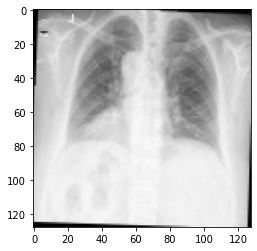

In [ ]:
plt.imshow(image_aug)

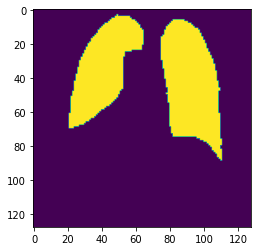

In [ ]:
plt.imshow(segmap_aug)

adding sequences for each type

In [ ]:
horizontal_flip_seq = iaa.Sequential([
    iaa.Fliplr(1.0)
])

rotation_seq = seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30))])

shear_flip_seq = seq = iaa.Sequential([iaa.Affine(shear=1.0),
                                       iaa.Fliplr(1.0)
                                       ])
rotation_flip_seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)), # rotate the image
    iaa.Fliplr(1.0)
])

In [ ]:
sequences = [horizontal_flip_seq,rotation_seq,shear_flip_seq,rotation_flip_seq]

In [ ]:
horizontal_flip_images = []
rotation_images = []
shear_flip_images = []
rotation_flip_images = []

aug_images  = [horizontal_flip_images,rotation_images,shear_flip_images,rotation_flip_images]

In [ ]:
horizontal_flip_masks = []
rotation_masks = []
shear_flip_masks = []
rotation_flip_masks = []

aug_masks  = [horizontal_flip_masks,rotation_masks,shear_flip_masks,rotation_flip_masks]

In [ ]:
for count,current_images in enumerate(aug_images):
  
  duplicate_images = train_images.copy()
  duplicate_masks = train_masks.copy()

  m = duplicate_images.shape[0]

  current_masks = aug_masks[count]

  for i in range(m):

    segmap_to_aug = SegmentationMapOnImage(duplicate_masks[i],shape=duplicate_masks[i].shape,nb_classes=2)

    current_seq = sequences[count]

    image_aug, segmap_aug = current_seq(image=duplicate_images[i], segmentation_maps=segmap_to_aug)

    segmap_aug = segmap_aug.get_arr_int()
    segmap_aug = np.expand_dims(segmap_aug,axis=-1)

    current_images.append(image_aug)
    current_masks.append(segmap_aug)


checking whether it is done properly or not by visualizing

In [ ]:
i=1

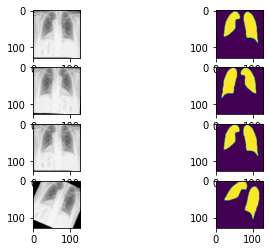

In [ ]:
for count,current_images in enumerate(aug_images):

  plt.subplot(4,2,i)
  plt.imshow(current_images[23])
  
  i+=1 

  plt.subplot(4,2,i)
  plt.imshow(aug_masks[count][23].squeeze(axis=-1))

  i+=1

In [ ]:
train_images = np.concatenate((train_images,np.stack(aug_images[0]),np.stack(aug_images[1]),np.stack(aug_images[2]),np.stack(aug_images[3])))
train_masks = np.concatenate((train_masks,np.stack(aug_masks[0]),np.stack(aug_masks[1]),np.stack(aug_masks[2]),np.stack(aug_masks[3])))

In [ ]:
train_images.shape,train_masks.shape

((3520, 128, 128, 3), (3520, 128, 128, 1))

shuufle data

In [ ]:
from sklearn.utils import shuffle
train_images,train_masks = shuffle(train_images,train_masks)
train_images.shape,train_masks.shape

((3520, 128, 128, 3), (3520, 128, 128, 1))

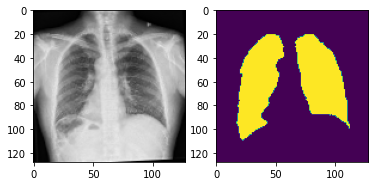

In [ ]:
# checking that data don't get mismatched
plt.subplot(1,2,1)
plt.imshow(train_images[23])
plt.subplot(1,2,2)
plt.imshow(train_masks[23].squeeze(axis=-1))

#Building and traing Model

In [ ]:
from keras import backend as K


def jaccard_distance(y_true, y_pred, smooth=100):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if
    each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat.
    If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy)
    or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # Arguments
        y_true: The ground truth tensor.
        y_pred: The predicted tensor
        smooth: Smoothing factor. Default is 100.
    # Returns
        The Jaccard distance between the two tensors.
    # References
        - [What is a good evaluation measure for semantic segmentation?](
           http://www.bmva.org/bmvc/2013/Papers/paper0032/paper0032.pdf)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [ ]:

def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss=jaccard_distance,metrics=["accuracy"])
  return model




In [ ]:
U_Net_model = build_unet((128,128,3))

In [ ]:
U_Net_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
train_images = tf.convert_to_tensor(train_images)
train_masks = tf.convert_to_tensor(train_masks)
train_masks = tf.cast(train_masks,tf.float32)

In [ ]:
Earlystopper = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [ ]:
U_Net_model.fit(train_images,train_masks,validation_split=0.08,epochs=6,callbacks=[Earlystopper])

Epoch 1/6
102/102 [==============================] - 108s 487ms/step - loss: 0.0982 - accuracy: 0.9245 - val_loss: 0.1603 - val_accuracy: 0.8736
Epoch 2/6
102/102 [==============================] - 45s 443ms/step - loss: 0.0252 - accuracy: 0.9781 - val_loss: 0.1618 - val_accuracy: 0.8625
Epoch 3/6
102/102 [==============================] - 48s 467ms/step - loss: 0.0220 - accuracy: 0.9795 - val_loss: 0.1747 - val_accuracy: 0.8224
Epoch 4/6
102/102 [==============================] - 47s 457ms/step - loss: 0.0203 - accuracy: 0.9805 - val_loss: 0.0766 - val_accuracy: 0.9235
Epoch 5/6
102/102 [==============================] - 47s 461ms/step - loss: 0.0208 - accuracy: 0.9797 - val_loss: 0.0260 - val_accuracy: 0.9745
Epoch 6/6
102/102 [==============================] - 47s 458ms/step - loss: 0.0197 - accuracy: 0.9806 - val_loss: 0.0214 - val_accuracy: 0.9788


#Evaluating Model

In [ ]:
idx = 23
sample_pred = U_Net_model.predict(tf.expand_dims(train_images[idx],axis=0))

In [ ]:
np.max(sample_pred),np.min(sample_pred)

(0.9999999, 2.4757588e-05)

In [ ]:
sample_pred = sample_pred.reshape(128,128)

In [ ]:
sample_pred = (sample_pred>0.05).astype(np.uint8)

In [ ]:
np.min(sample_pred),sample_pred.shape

(0, (128, 128))

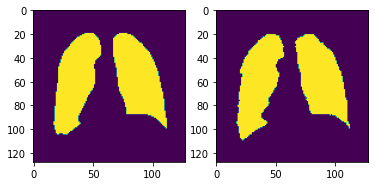

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sample_pred.reshape(128,128))
plt.subplot(1,2,2)
plt.imshow(tf.reshape(train_masks[idx],(128,128)))

In [ ]:
n_classes=2
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001
  
  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


In [ ]:
width=height=128

In [ ]:
class_wise_iou,class_wise_dice_score = class_wise_metrics(train_masks[23].numpy().reshape(width,height),sample_pred)

In [ ]:
print(class_wise_iou[1])

0.9436141282979753


In [ ]:
class_names = ['background','segmented_area']

In [ ]:
def calc_average_class_metrics(train_images,train_labels,model,class_metric_fnc,class_names):

  average_iou = [0.0,0,0]
  average_dice_score = [0.0,0.0]

  m=train_images.shape[0]

  y_predicteds = model.predict(train_images)
  y_predicteds = y_predicteds.squeeze(axis=-1)
  y_predicteds = (y_predicteds > 0.1).astype(np.int32)

  train_labels = train_labels.squeeze(axis=-1)

  for i in range(m):
    iou,dice_score = class_metric_fnc(train_labels[i],y_predicteds[i])
    
    average_iou[0]+=iou[0]
    average_dice_score[0]+=dice_score[0]
    
    average_iou[1]+=iou[1]
    average_dice_score[1]+=dice_score[1]

  
  average_iou = list(map(lambda x:x/m,average_iou))
  average_dice_score = list(map(lambda x:x/m,average_dice_score))
  
  print("========================IOU score=============================")
  for i,class_name in enumerate(class_names):
    print(f"{class_name}: {average_iou[i]}")
  
  print("---------------------------------------------------------------------------------")

  print("========================Dice score=============================")
  for i,class_name in enumerate(class_names):
    print(f"{class_name}: {average_dice_score[i]}")


In [ ]:
calc_average_class_metrics(train_images.numpy(),train_masks.numpy(),U_Net_model,class_wise_metrics,class_names)

========================IOU score=============================
background: 0.974239458416494
segmented_area: 0.9259834225118458
---------------------------------------------------------------------------------
========================Dice score=============================
background: 0.9868671100525983
segmented_area: 0.9610050549067773


In [ ]:
'''IOU score is 92.59834225118458 % which is pretty high'''

'IOU score is 92.59834225118458 % which is pretty high'